In [2]:
from ves import *
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import load_iris
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from scipy.stats import uniform
from xgboost import XGBRegressor

In [3]:
# Load the diabetes dataset (for regression)
Xd, Yd = load_iris(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor()

# and compute a baseline to beat with hyperparameter optimization 
baseline = cross_val_score(xgb, Xd, Yd, scoring='neg_mean_squared_error').mean()

In [4]:
# Global parameters
BOUNDS = torch.zeros(2,2)
BOUNDS[:, 1] = torch.ones(2)
NUM_INIT = 2
NUM_TRIALS = 10
NUM_ITER = 48
NUM_PATHS = 64
# 2D discretization parameters
nx = 101
ny = 101

In [5]:
def f_dp(X):
    if isinstance(X, tuple):
        x,y = X
    elif X.ndim != 2:
        x,y = X[0],X[1]
    else:
        x,y = X[:,0],X[:,1]
    y = 5 * y
    n = len(x)
    ans = torch.zeros(n, dtype=torch.double)
    for i in range(n):
        ans[i] = cv_bh((x[i].item(), y[i].item(), 10, 50, 5))
    return ans

def cv_bh(parameters):
    xgb = XGBRegressor(learning_rate=parameters[0],
                        gamma=parameters[1],
                        max_depth=int(parameters[2]),
                        n_estimators=int(parameters[3]),
                        min_child_weight = parameters[4])
    score = cross_val_score(xgb, Xd, Yd, scoring='neg_mean_squared_error').mean()
    return torch.tensor(score)

/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666647174771/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Maximizer is  tensor([0.5000, 0.0800]) with value  -0.05598949212936547


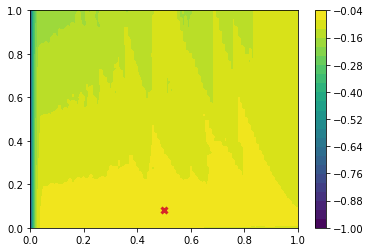

In [6]:
# plot function f_sn
X1,X2 = torch.linspace(BOUNDS[0,0], BOUNDS[0,1], nx),torch.linspace(BOUNDS[1,0], BOUNDS[1,1], ny)
Xx,Xy = torch.meshgrid(X1, X2)
X = torch.vstack((Xx.flatten(), Xy.flatten())).T
Y = f_dp(X)
max_id = torch.argmax(Y)
max_Y = torch.max(Y)
plt.plot(X[max_id, 0], X[max_id, 1], 'kx', mew=3, c='tab:red')
plt.contourf(Xx, Xy, Y.reshape(nx, ny), 25)
plt.colorbar()
print('Maximizer is ',X[max_id], 'with value ', max_Y.item())

In [7]:
ves_dp, ei_dp, mes_dp = run_2d_experiment(f_dp,
                                  bounds=BOUNDS,
                                  num_init=NUM_INIT,
                                  num_trials=NUM_TRIALS,
                                  num_iter=48,
                                  num_paths=NUM_PATHS,
                                  nx=nx,
                                  ny=ny)
ves_dp, ei_dp, mes_dp = np.log(max_Y - ves_dp), np.log(max_Y - ei_dp), np.log(max_Y - mes_dp)
ves_dp_mean, ei_dp_mean, mes_dp_mean = ves_dp.mean(axis=0), ei_dp.mean(axis=0), mes_dp.mean(axis=0)
ves_dp_std, ei_dp_std, mes_dp_std = ves_dp.std(axis=0), ei_dp.std(axis=0), mes_dp.std(axis=0)

100%|██████████| 10/10 [50:30<00:00, 303.03s/it]


In [8]:
ves_dp_mean, ei_dp_mean, mes_dp_mean = np.nanmean(ves_dp.detach().numpy(), axis=0), np.nanmean(ei_dp.detach().numpy(), axis=0), np.nanmean(mes_dp.detach().numpy(), axis=0)
ves_dp_std, ei_dp_std, mes_dp_std = np.nanstd(ves_dp.detach().numpy(), axis=0), np.nanstd(ei_dp.detach().numpy(), axis=0), np.nanstd(mes_dp.detach().numpy(), axis=0)

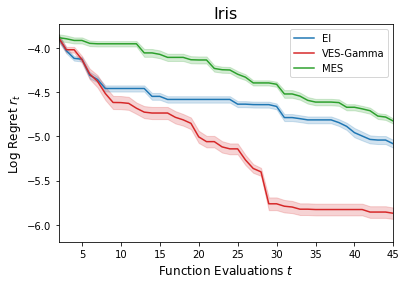

In [12]:
fig, axs = plt.subplots(figsize=(6,4))
ei_mean, ei_std, ves_mean, ves_std, mes_mean, mes_std = ei_dp_mean, ei_dp_std, ves_dp_mean, ves_dp_std, mes_dp_mean, mes_dp_std
std_cont = 0.1
axs.plot(np.arange(len(ves_mean))+NUM_INIT, ei_mean, label='EI', c='tab:blue')
axs.fill_between(np.arange(len(ei_mean))+NUM_INIT, ei_mean-std_cont*ei_std, ei_mean+std_cont*ei_std, color='tab:blue', alpha=0.2)
axs.plot(np.arange(len(ves_mean))+NUM_INIT, ves_mean, label='VES-Gamma', c='tab:red')
axs.fill_between(np.arange(len(ves_mean))+NUM_INIT, ves_mean-std_cont*ves_std, ves_mean+std_cont*ves_std, color='tab:red', alpha=0.2)
axs.plot(np.arange(len(mes_mean))+NUM_INIT, mes_mean, label='MES', c='tab:green')
axs.fill_between(np.arange(len(mes_mean))+NUM_INIT, mes_mean-std_cont*mes_std, mes_mean+std_cont*mes_std, color='tab:green', alpha=0.2)
axs.legend()
axs.set_xlabel(r'Function Evaluations $t$', fontsize=12)
axs.set_ylabel(r'Log Regret $r_t$', fontsize=12)
axs.set_title('Iris', fontsize=16)
axs.set_xlim([2, 45])
fig.savefig('iris.pdf', dpi=300, bbox_inches='tight')